<a href="https://colab.research.google.com/github/SomTambe/omniglot-bcs/blob/master/one_hot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/SomTambe/omniglot-bcs/raw/master/splines.py
!wget https://github.com/SomTambe/omniglot-bcs/raw/master/encoded.py
!wget https://github.com/SomTambe/omniglot-bcs/raw/master/weights/2-d/decoder.pth
!wget https://github.com/SomTambe/omniglot-bcs/raw/master/weights/2-d/encoder.pth
!wget https://github.com/SomTambe/omniglot-bcs/raw/master/data_background.mat

--2020-07-07 05:45:11--  https://github.com/SomTambe/omniglot-bcs/raw/master/splines.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SomTambe/omniglot-bcs/master/splines.py [following]
--2020-07-07 05:45:12--  https://raw.githubusercontent.com/SomTambe/omniglot-bcs/master/splines.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4642 (4.5K) [text/plain]
Saving to: ‘splines.py’

splines.py          100%[===================>]   4.53K  --.-KB/s    in 0s      

2020-07-07 05:45:12 (67.9 MB/s) - ‘splines.py’ saved [4642/4642]

--2020-07-07 05:45:16--  https://github.com/SomTambe/omniglot-bcs/raw/maste

In [2]:
import splines
import torch
import glob
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchsummary import summary
import scipy
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import plotly.express as px
import encoded
from torch.utils.data import IterableDataset, DataLoader
!nvidia-smi

Tue Jul  7 05:45:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device="cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [4]:
back_dict=splines.mat_to_dict()
spline_prims=splines.spline_dict(back_dict)
images=splines.dict_images()

In [5]:
dataset=encoded.OmniglotData(spline_prims)
data_loader=DataLoader(dataset,batch_size=1,shuffle=False) # Using batchsize 1 to get single primitive at a time.
# Create instances of models
enc=encoded.encoder(latent_dim=2).to(device)
dec=encoded.decoder(latent_dim=2).to(device)
# Loading weights
# enc.load_state_dict(torch.load('./weights/2-d/encoder.pth',map_location=torch.device('cpu')))
# dec.load_state_dict(torch.load('./weights/2-d/decoder.pth',map_location=torch.device('cpu')))
enc.load_state_dict(torch.load('encoder.pth'))
dec.load_state_dict(torch.load('decoder.pth'))

<All keys matched successfully>

In [6]:
x_2d=[]
y_2d=[]
for i,data in tqdm(enumerate(data_loader)):
    data=data.to(device)
    mu,var=enc(data)
    lat_var=encoded.gen_latent(mu,var).squeeze().detach().cpu().numpy()
    x_2d.append(lat_var[0].item());y_2d.append(lat_var[1].item())

In [7]:
from sklearn.cluster import KMeans
import time
start=time.time()
X=np.concatenate((np.reshape(x_2d,(-1,1)),np.reshape(y_2d,(-1,1))),axis=1)
kmeans = KMeans(300, random_state=0)
labels = kmeans.fit(X).predict(X)
print("%d"%(time.time()-start))

67


In [8]:
print(len(labels))
print('max: ',np.max(labels,0))

48762
max:  299


In [38]:
# Let us now prepare the dataloader for the next model, for performing 
# supervised learning using the one-hot encoded vectors of a particular character.

class OneHotDataset(IterableDataset):
    """
    Iterable form dataset for providing one-hot encoded vectors for each character.
    
    Args:
        data (dict): Just pass the spline_prims variable.
        images (dict): Just pass the image dict.
        labels (iterable type object): Labels for clustered data.
        
    Returns:
        (Tensor) : One-hot encoded vector of length 300. (image,target)
    """
    def __init__(self,data,images,labels,oh_len):
        self.data=data
        self.images=images
        self.labels=labels
        self.oh_len=oh_len
    
    def stream(self):
        # spline_prims[lang][char][inst][0][primitive]
        # images[lang][char][0]['image'][inst][0] -> (105,105) numpy ndarray
        count=0
        for lang in self.data:
            for i,char in enumerate(self.data[lang]):
                for j,inst in enumerate(char):
                    vector=np.zeros((self.oh_len))
                    for prim in inst[0]:
                        # yield torch.tensor(prim.reshape(-1)).float()
                        # yield torch.tensor(self.normalize(prim).reshape(-1)).float()
                        idx=self.labels[count]
                        # vector[idx]+=1.
                        if vector[idx]==0:
                            vector[idx]+=1.
                        count+=1
                    # yield [image,vector]
                    img=self.images[lang][i][0]['image'][j][0]
                    yield [torch.tensor(img).unsqueeze(0).float(),torch.tensor(vector).float()]
                    
    def __len__(self):
        return int(19280) # Literally meaningless, hardcoded
    
    def __iter__(self):
        return self.stream()
        

In [75]:
def which_cluster(vector):
    """
    Dummy function to just give the indices of the clusters.
    
    Arg:
        vector: You know what it is.
    """
    vector=vector.reshape(-1)
    which=[]
    idx=0
    for _ in vector:
        # if vector[idx]==1:
        #     which.append(idx)
        # if vector[idx]>1:
        #     which.append('{0},special'.format(idx))
        if vector[idx]>0:
            which.append(idx)
        idx+=1
    return which

In [40]:
dataset=OneHotDataset(data=spline_prims,images=images,labels=labels,oh_len=300)
data_loader=DataLoader(dataset,batch_size=1)

[22, 152, 172, 184, 236]


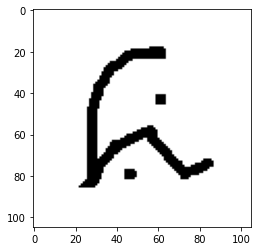

In [43]:
plot=96
for k,i in enumerate(data_loader):
#     print(i[0].shape,i[1].shape)
    if plot==k:
        print(which_cluster(i[1]))
        plt.imshow(i[0].squeeze().detach().cpu().numpy(),cmap='gray')
        break
#     print(type(i[0]),type(i[1]))
#     print(which_cluster(i[1]))
plt.show()

In [44]:
len(data_loader)

19280

In [45]:
# Lets build the CNN now.

In [54]:
class one_hot_network(nn.Module):
    def __init__(self):
        super().__init__()
        self.block=nn.Sequential(
            nn.Conv2d(1,32,(7,7),stride=2), # outputs 50x50 image
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32,32,(3,3),stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32,32,(3,3),stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32,64,(3,3),stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64,64,(3,3),stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64,256,(3,3),stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256,512,(3,3),stride=2), ##
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512,1024,(3,3),stride=2),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
        )
        self.fc=nn.Sequential(
            nn.Linear(1024*2*2,300)
        )

    def forward(self,x):
        bsize=x.size(0)
        x=self.block(x)
        x=x.view(bsize,-1)
        x=self.fc(x)
        return F.sigmoid(x)

In [62]:
net=one_hot_network().to(device)

In [63]:
summary(net,(1,105,105))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]           1,600
       BatchNorm2d-2           [-1, 32, 50, 50]              64
              ReLU-3           [-1, 32, 50, 50]               0
            Conv2d-4           [-1, 32, 50, 50]           9,248
       BatchNorm2d-5           [-1, 32, 50, 50]              64
              ReLU-6           [-1, 32, 50, 50]               0
            Conv2d-7           [-1, 32, 50, 50]           9,248
       BatchNorm2d-8           [-1, 32, 50, 50]              64
              ReLU-9           [-1, 32, 50, 50]               0
           Conv2d-10           [-1, 64, 24, 24]          18,496
      BatchNorm2d-11           [-1, 64, 24, 24]             128
             ReLU-12           [-1, 64, 24, 24]               0
           Conv2d-13           [-1, 64, 24, 24]          36,928
      BatchNorm2d-14           [-1, 64,

In [64]:
num_epochs=100

In [65]:
data_loader=DataLoader(dataset,batch_size=32)
criterion=nn.MSELoss()
opt=optim.Adam(net.parameters(),lr=1e-5)

In [66]:
import warnings
warnings.filterwarnings("ignore")

In [67]:
for epoch in range(num_epochs):
    running_loss=.0
    for i,data in enumerate(data_loader):
        data,target=data[0].to(device),data[1].to(device)
        out=net(data)
        loss=criterion(out,target)

        loss.backward()
        opt.step()

        running_loss+=loss.item()
    print("[%d/%d]  running_loss=%.3f"%(epoch+1,num_epochs,running_loss))

[1/100]  running_loss=13.242
[2/100]  running_loss=4.932
[3/100]  running_loss=4.932
[4/100]  running_loss=4.932
[5/100]  running_loss=4.932
[6/100]  running_loss=4.932
[7/100]  running_loss=4.932
[8/100]  running_loss=4.932
[9/100]  running_loss=4.932
[10/100]  running_loss=4.932
[11/100]  running_loss=4.932
[12/100]  running_loss=4.932
[13/100]  running_loss=4.932
[14/100]  running_loss=4.932
[15/100]  running_loss=4.932
[16/100]  running_loss=4.932
[17/100]  running_loss=4.932
[18/100]  running_loss=4.932
[19/100]  running_loss=4.932
[20/100]  running_loss=4.932
[21/100]  running_loss=4.932
[22/100]  running_loss=4.932
[23/100]  running_loss=4.932
[24/100]  running_loss=4.932
[25/100]  running_loss=4.932
[26/100]  running_loss=4.932
[27/100]  running_loss=4.932
[28/100]  running_loss=4.932
[29/100]  running_loss=4.932


KeyboardInterrupt: ignored

In [85]:
def eval_chr_vector(chr):
    """
    Function to evaluate the one-hot vector of given chr index.
    Args:
        chr (int): Index of character you want to test. Must be lesser than 19280.
    """
    dataset=OneHotDataset(data=spline_prims,images=images,labels=labels,oh_len=300)
    d_loader=DataLoader(dataset,batch_size=1)

    for i,data in enumerate(d_loader):
        if i==chr:
            og_vec=data[1]
            d_vec=net(data[0].to(device))
            # print(which_cluster(og_vec.squeeze()),which_cluster(d_vec.squeeze()))
            return (which_cluster(og_vec.squeeze()),which_cluster(d_vec.squeeze()))

In [87]:
eval_chr_vector(1928)

([128], [])